# Spark & Python
# Fitting and Evaluating Regression Models

## Introduction

* A regression algorithm is a supervised learning algorithm.
    * The inputs are called *features*
    * The output is called the *label*

* A regression model provides a prediction of a continuous numerical label.

* Spark MLlib provides several regression algorithms:
   * Linear Regression (with Elastic Net, Lasso, and Ridge Regression)
   * Isotonic Regression
   * Decision Tree
   * Random Forest
   * Gradient-Boosted Trees

* Spark MLlib also provides regression algorithms for special types of continuous numerical labels:
   * Generalized Regression
   * Survival Regression

* Spark MLlib requires the features to be assembled into a vector of doubles column.


## Scenario

We will build a regression model to predict the duration of a ride from
the distance of the ride.  We can then use this regression model in our
mobile application to provide a real-time estimate of arrival time.
In the demonstration, we will use linear regression.  In the exercise, we will
use isotonic regression.


## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Start a SparkSession

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("regress").getOrCreate()

## Load the data

In [3]:
# Read the (clean) ride data from the file system here:
rides = spark.read.parquet("file:///workdir/spark-3.0.1-bin-hadoop2.7-hive1.2/spark-ml/duocar/clean/rides/")
rides.printSchema()


root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- utc_offset: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- origin_lat: decimal(9,6) (nullable = true)
 |-- origin_lon: decimal(9,6) (nullable = true)
 |-- dest_lat: decimal(9,6) (nullable = true)
 |-- dest_lon: decimal(9,6) (nullable = true)
 |-- distance: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- cancelled: boolean (nullable = true)
 |-- star_rating: integer (nullable = true)



## Prepare the regression data

Select the feature (x) and the label (y) and filter out the cancelled rides:


In [4]:
regression_data = rides.select("distance", "duration").filter("cancelled = 0")

## Plot the data

Plot the ride duration versus the ride distance on a random sample of rides using pandas:

<AxesSubplot:xlabel='distance', ylabel='duration'>

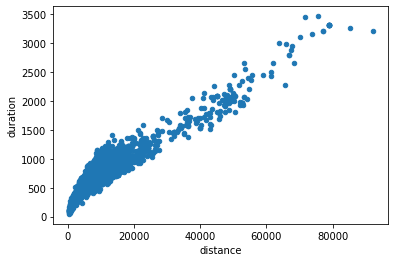

In [5]:
regression_data \
  .sample(withReplacement=False, fraction=0.1, seed=12345) \
  .toPandas() \
  .plot.scatter(x="distance", y="duration")

## Assemble the feature vector

Import the `VectorAssembler` class from the `pyspark.ml.feature` module:

In [6]:
from pyspark.ml.feature import VectorAssembler

Create an instance of the `VectorAssembler` class:

In [7]:
assembler = VectorAssembler(inputCols=["distance"], outputCol="features")

Call the `transform` method to assemble the feature vector:

In [8]:
assembled = assembler.transform(regression_data)

Examine the transformed DataFrame:

In [9]:
assembled.printSchema()
assembled.show(5)

root
 |-- distance: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- features: vector (nullable = true)

+--------+--------+---------+
|distance|duration| features|
+--------+--------+---------+
|   10123|     729|[10123.0]|
|   16043|    1299|[16043.0]|
|    9362|     736| [9362.0]|
|    9060|     773| [9060.0]|
|    5076|     721| [5076.0]|
+--------+--------+---------+
only showing top 5 rows



**Note:** The `VectorAssembler` instance is an example of a Spark MLlib
`Transformer`.  It takes a DataFrame as input and returns a DataFrame as
output via the `transform` method.


## Create a train and test set

Use the `randomSplit` method to create random partitions of the data:

In [15]:
(train, test) = assembled.randomSplit(weights=[0.7, 0.3], seed=23451)

We will fit the regression model on the `train` DataFrame
and evaluate it on the `test` DataFrame.


## Specify a linear regression model

Import the `LinearRegression` class from the `pyspark.ml.regression` module:

In [16]:
from pyspark.ml.regression import LinearRegression

Create an instance of the `LinearRegression` class:

In [17]:
lr = LinearRegression(featuresCol="features", labelCol="duration")

Examine additional hyperparameters;

In [18]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: duration)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
regParam: regularization parameter (>= 0). (default: 0.0)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardization: whether to standardize the train

## Fit the linear regression model

Call the `fit` method to fit the linear regression model on the `train` data:

In [19]:
lr_model = lr.fit(train)

The `fit` method returns an instance of the `LinearRegressionModel` class:

In [20]:
type(lr_model)

pyspark.ml.regression.LinearRegressionModel

**Note:** The `LinearRegression` instance is an example of a Spark MLlib
`Estimator`.  It takes a DataFrame as input and returns a `Transformer` as
output via the `fit` method.


## Examine the model parameters

Access the `intercept` and `coefficients` attributes to get the intercept and
slope (for each feature) of the linear regression model:

In [21]:
lr_model.intercept
lr_model.coefficients

DenseVector([0.0383])

The slope is stored as a `DenseVector`.  Call the `toArray` method to convert
the DenseVector to a NumPy array:

In [22]:
lr_model.coefficients.toArray()

array([0.0382956])

## Examine various model performance measures

The `summary` attribute is an instance of the `LinearRegressionTrainingSummary` class:

In [23]:
type(lr_model.summary)

pyspark.ml.regression.LinearRegressionTrainingSummary

It contains a number of model performance measures:

In [24]:
lr_model.summary.r2
lr_model.summary.rootMeanSquaredError

131.65629110561895

## Examine various model diagnostics

The `summary` attribute also contains various model diagnostics:

In [26]:
lr_model.summary.coefficientStandardErrors
lr_model.summary.tValues
lr_model.summary.pValues

[0.0, 0.0]

**Important:** The first element of each list corresponds to the slope and
the last element corresponds to the intercept.

**Note:** The summary attribute contains additional useful information.
  

## Apply the linear regression model to the test data

Use the `transform` method to apply the linear regression model to the `test` DataFrame:

In [27]:
predictions = lr_model.transform(test)

The `transform` method adds a column to the DataFrame with the predicted label:

In [28]:
predictions.printSchema()
predictions.show(5)

root
 |-- distance: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------+--------+--------+-----------------+
|distance|duration|features|       prediction|
+--------+--------+--------+-----------------+
|     342|      35| [342.0]|358.7746579280776|
|     390|      28| [390.0]|360.6128469503565|
|     396|      79| [396.0]|360.8426205781414|
|     421|      89| [421.0]|361.8000106939117|
|     433|     109| [433.0]|362.2595579494814|
+--------+--------+--------+-----------------+
only showing top 5 rows



## Evaluate the linear regression model on the test data

Import the `RegressionEvaluator` class from the `pyspark.ml.evaluation` module:

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

Create an instance of the `RegressionEvaluator` class:

In [30]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="duration", metricName="r2")

Call the `explainParams` method to see other metrics:

In [31]:
print(evaluator.explainParams())

labelCol: label column name. (default: label, current: duration)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error
                       var - explained variance. (default: rmse, current: r2)
predictionCol: prediction column name. (default: prediction, current: prediction)
throughOrigin: whether the regression is through the origin. (default: False)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)


Use the `evaluate` method to compute the metric on the `predictions` DataFrame:

In [32]:
evaluator.evaluate(predictions)

0.8690285984936144

Use the `setMetricName` method to change the metric:

In [33]:
evaluator.setMetricName("rmse").evaluate(predictions)

132.40789632439325

**Note:** You can also use the `evaluate` method of the `LinearRegressionModel` class.


## Plot the linear regression model

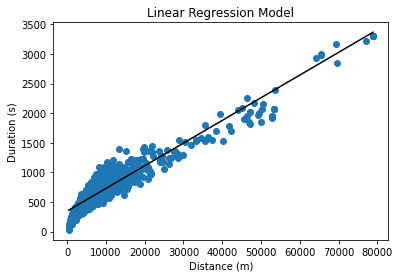

In [34]:
def plot_lr_model():
  pdf = predictions.sample(withReplacement=False, fraction= 0.1, seed=34512).toPandas()
  plt.scatter("distance", "duration", data=pdf)
  plt.plot("distance", "prediction", color="black", data=pdf)
  plt.xlabel("Distance (m)")
  plt.ylabel("Duration (s)")
  plt.title("Linear Regression Model")

    
plot_lr_model()

Free resources

In [35]:
spark.stop()